In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [2]:
import pickle
import gzip
import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('drive/My Drive/ML Project/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.
    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10,1))
    e[j] = 1.0
    return e

In [3]:
# import
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Input, Conv2D, MaxPooling2D,AveragePooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
import keras.backend as K

In [4]:
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)
test_data = list(test_data) 
# normalize training images and convert them to numpy array
x_train = np.array([x[0] / 255 for x in training_data]).squeeze()
y_train = np.array([x[1] for x in training_data]).squeeze()
x_test = np.array([x[0] / 255 for x in test_data]).squeeze()
y_test = to_categorical(np.array([x[1] for x in test_data]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 784) (50000, 10) (10000, 784) (10000, 10)


In [5]:
input_shape = (784, )
num_classes = 10

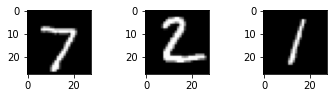

In [6]:
for i in range(3):
  pyplot.subplot(330 + 1 + i)
  # plot raw pixel data
  pyplot.imshow(np.reshape(x_test[i], (28, 28)), cmap=pyplot.get_cmap('gray'))

# Set up model and run

In [7]:
def define_model(h1_size = 64, h2_size = 32, lr=0.01, kernel_init= 'zeros', bias_init = 'zeros'):
  input_img = Input(shape= (784, ), name='input_img')
  l = Dense(h1_size, activation='sigmoid', kernel_initializer=kernel_init, bias_initializer = bias_init)(input_img)
  l = Dense(h2_size, activation='sigmoid', kernel_initializer=kernel_init, bias_initializer = bias_init)(l)
  output_class = Dense( 10 , activation='softmax')(l)

  model_initial = Model(inputs=input_img, outputs=output_class)
  opt = SGD(learning_rate=lr)
  model_initial.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer=opt
              )
  return model_initial
  # model = Sequential()
  # model.add(Dense(64, input_shape=(784,)))
  # model.add(Activation('sigmoid'))                            

  # model.add(Dense(512))
  # model.add(Activation('sigmoid'))

  # model.add(Dense(32))
  # model.add(Activation('softmax'))
  # model.compile(loss='categorical_crossentropy', 
  #             metrics=['accuracy'])
  # return model

In [8]:
model_first = define_model()
model_first.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


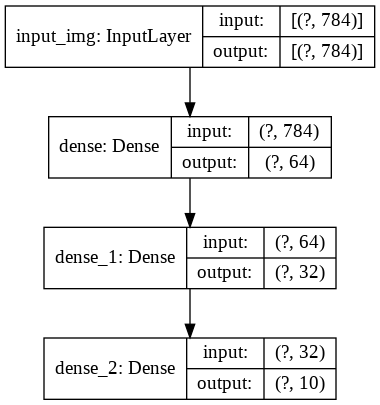

In [9]:
plot_model(model_first, show_shapes= True)

In [10]:
print(len(x_train), len(y_train), x_train[0].shape, y_train[0].shape, type(x_train), )
print(type(x_train[0]), type(y_train[0]))
model_first.fit(x_train, y_train, verbose=1, epochs = 10)


50000 50000 (784,) (10,) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Epoch 1/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3091 - accuracy: 0.1096
Epoch 2/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3018 - accuracy: 0.1123
Epoch 3/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3019 - accuracy: 0.1133
Epoch 4/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3018 - accuracy: 0.1134
Epoch 5/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3019 - accuracy: 0.1123
Epoch 6/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3017 - accuracy: 0.1127
Epoch 7/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3018 - accuracy: 0.1128
Epoch 8/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3019 - accuracy: 0.1123
Epoch 9/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3018 - ac

In [11]:
# evaluate model
_, acc = model_first.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 0s 1ms/step - loss: 2.3014 - accuracy: 0.1135


# Optimisations

## Varying size of hidden layers
Two hidden layers are used which are both initialised to 64 and 32 respectively. The size of layers would be changed to see how the accuracy changes.

In [12]:
def plot_acc(x_val, y_vals, title):
  fig = pyplot.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(x_val, y_vals, color = 'blue')
  ax.set_ylabel('Accuracy')
  ax.set_title(title)
  pyplot.show()

def plot_loss(x_val, y_vals, title):
  fig = pyplot.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(x_val, y_vals, color = 'red')
  ax.set_ylabel('Loss')
  ax.set_title(title)
  pyplot.show()

In [13]:
h1_values = [512, 256, 128, 64, 32, 16, 8]
h2_values = [512, 256, 128, 64, 32, 16, 8]
 

> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350


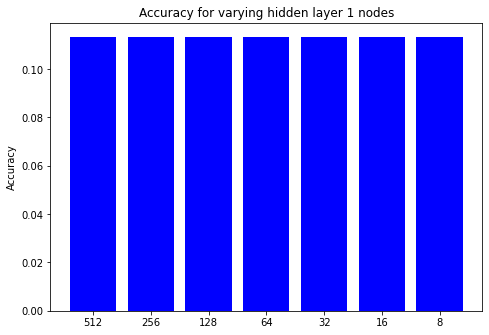

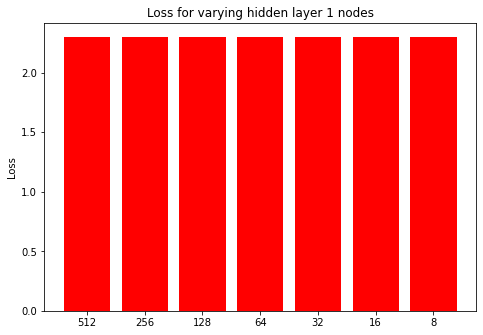

In [23]:
# only change h1_values
scores = []
histories = []
losses = []
for x in h1_values:
  model_temp  = define_model(h1_size=  x)
  history = model_temp.fit(x_train, y_train, epochs = 10, verbose = 0)
  loss, acc = model_temp.evaluate(x_test, y_test, verbose=0)
  print('> %.3f' % (acc * 100.0))
  # stores scores
  scores.append(acc)
  histories.append(history)
  losses.append(loss)

plot_acc(list(map(str, h1_values)), [np.mean(x) for x in scores], 'Accuracy for varying hidden layer 1 nodes')
plot_loss(list(map(str, h1_values)), [np.mean(x) for x in losses], 'Loss for varying hidden layer 1 nodes')

In [22]:
print('%d %d' % (2 , 3))

2 3


> 10.280
> 11.350
> 11.350
> 11.350
> 10.100
> 9.800
> 11.350
> 11.350
> 10.320
> 10.280
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 10.320
> 9.580
> 11.350
> 11.350
> 11.350
> 11.350
> 10.320
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 11.350
> 8.920
> 9.820
> 11.350
> 10.100
> 11.350
> 11.350
> 11.350


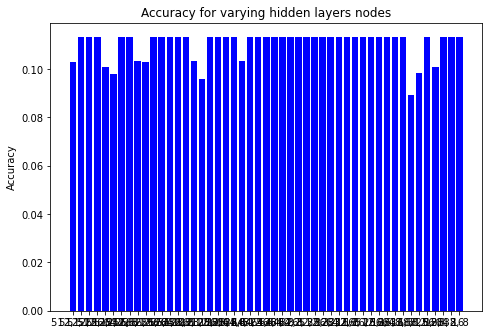

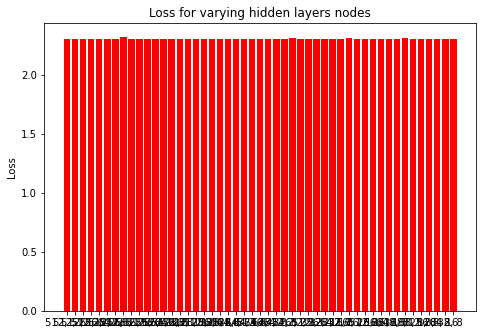

In [24]:
# change both h1 and h2
scores = []
histories = []
losses = []
values= []
max_comb = (0, (0,0))
for x in h1_values:
  for y in h2_values:
    model_temp  = define_model(h1_size=  x, h2_size= y)
    history = model_temp.fit(x_train, y_train, epochs = 10, verbose = 0)
    loss, acc = model_temp.evaluate(x_test, y_test, verbose=0)
    print('> %.3f' % (acc * 100.0))
    if (acc * 100.0) > max_comb[0]:
      max_comb = (acc * 100.0, (x, y))
    # stores scores
    scores.append(acc)
    histories.append(history)
    losses.append(loss)
    values.append('%d, %d' % (x, y))

plot_acc(values, [np.mean(x) for x in scores], 'Accuracy for varying hidden layers nodes')
plot_loss(values, [np.mean(x) for x in losses], 'Loss for varying hidden layers nodes')

In [25]:
print(max_comb)

(11.349999904632568, (512, 256))


Average accuracy acheived was close to 11.35 and so the size of hidden layers was set back to 64 and 32. As per the number of elements in hidden layers increase, accuracy increased but not to a large extent. 

Although the weights were initialised to zero and the bias too and so those need to be looked at.

## Varying learning rate
The learning rate for gradient descent will now be varied from 0.0001 to 1000 with each running with 10 epochs. 

In [26]:
lr = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

> 9.800
> 10.280
> 11.350
> 11.350
> 11.350
> 10.090
> 9.800
> 10.100
> 8.920
> 9.740


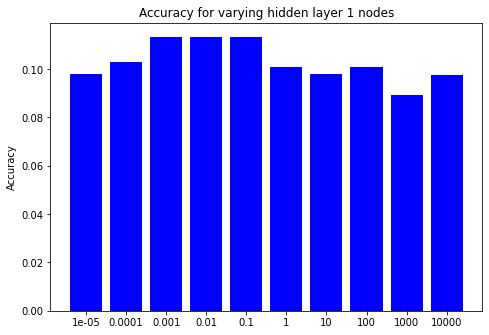

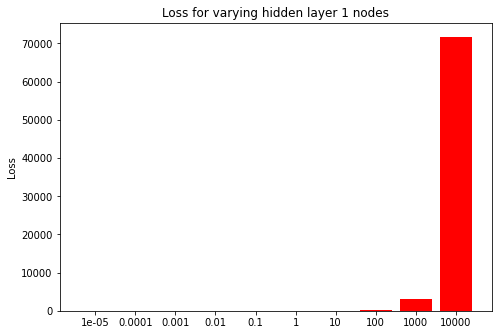

In [27]:
# only change weights
scores = []
losses = []
histories = []
for x in lr:
  model_temp  = define_model(lr = x)
  history = model_temp.fit(x_train, y_train, epochs = 10, verbose = 0)
  loss, acc = model_temp.evaluate(x_test, y_test, verbose=0)
  print('> %.3f' % (acc * 100.0))
  # stores scores
  losses.append(loss)
  scores.append(acc)
  histories.append(history)
plot_acc(list(map(str, lr)), [np.mean(x) for x in scores], 'Accuracy for varying hidden layer 1 nodes')
plot_loss(list(map(str, lr)), [np.mean(x) for x in losses], 'Loss for varying hidden layer 1 nodes')

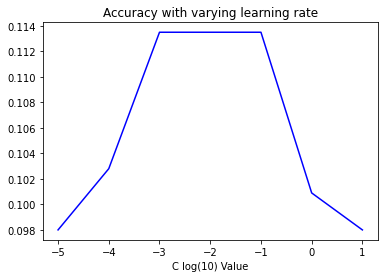

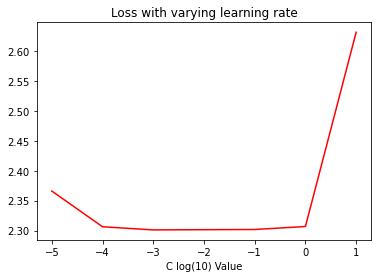

In [28]:
x = range(-5, 2)
y1 = [np.mean(i) for i in scores]
y2 = [np.mean(i) for i in losses]
pyplot.title('Accuracy with varying learning rate')
pyplot.plot(x, y1[:-3], color='blue')

# pyplot.plot(x, y2[:-3], color='red')
pyplot.xlabel('C log(10) Value')
# pyplot.legend(["Acc", "loss"])
pyplot.show()
pyplot.title('Loss with varying learning rate')
# pyplot.plot(x, y1[:-3], color='blue')

pyplot.plot(x, y2[:-3], color='red')
pyplot.xlabel('C log(10) Value')
# pyplot.legend(["Acc", "loss"])
pyplot.show()


this makes 0.001 the optimal lr since it has the minimum loss and highest accuracy.

## Different weight initializations

In [29]:
weights = ['zeros', 'ones', 'constant' ,'random_normal', 'random_uniform', 'truncated_normal', 'glorot_normal', 'glorot_uniform' ]

In [38]:
# only change weights
scores = []
losses = []
histories = []
for x in weights:
  print(x)
  model_temp  = define_model(kernel_init = x)
  history = model_temp.fit(x_train, y_train, epochs = 10, verbose = 0)
  loss, acc = model_temp.evaluate(x_test, y_test, verbose=0)
  print('> %.3f' % (acc * 100.0))
  # stores scores
  losses.append(loss)
  scores.append(acc)
  histories.append(history)

zeros
> 11.350
ones
> 11.350
constant
> 11.350
random_normal
> 11.350
random_uniform
> 11.350
truncated_normal
> 11.350
glorot_normal
> 11.350
glorot_uniform
> 11.350


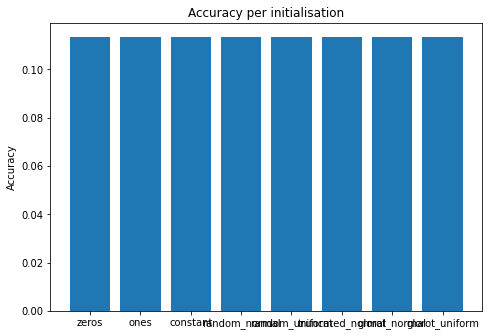

In [31]:
fig = pyplot.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(weights, [np.mean(i) for i in scores])
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy per initialisation')

pyplot.show()

In [32]:
def default_model(optimiser = 'sgd'):
  input_img = Input(shape= (784, ), name='input_img')
  l = Dense(64, activation='sigmoid')(input_img)
  l = Dense(32, activation='sigmoid')(l)
  output_class = Dense( 10 , activation='softmax')(l)

  model_initial = Model(inputs=input_img, outputs=output_class)
  
  model_initial.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer= optimiser
              )
  return model_initial

In [33]:
def_model  = default_model()
def_model.fit(x_train, y_train, epochs = 10)
loss, acc = def_model.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3150 - accuracy: 0.1102
Epoch 2/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3017 - accuracy: 0.1128
Epoch 3/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3018 - accuracy: 0.1132
Epoch 4/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3018 - accuracy: 0.1128
Epoch 5/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3015 - accuracy: 0.1127
Epoch 6/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3017 - accuracy: 0.1128
Epoch 7/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3016 - accuracy: 0.1123
Epoch 8/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3018 - accuracy: 0.1130
Epoch 9/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3017 - accuracy: 0.1130
Epoch 10/10
313/313 [==============================] - 0s 1ms/step - loss: 2.3015 

In [34]:
opts = ['sgd', 'adam', 'adagrad', 'rmsprop', 'adadelta', 'nadam']

In [35]:
# only change weights
scores1 = []
losses1 = []
histories1 = []
for x in opts:
  print(x)
  model_temp  = default_model(optimiser= x)
  history = model_temp.fit(x_train, y_train, epochs = 10, verbose = 0)
  loss, acc = model_temp.evaluate(x_test, y_test, verbose=0)
  print('> %.3f' % (acc * 100.0))
  # stores scores1
  losses1.append(loss)
  scores1.append(acc)
  histories1.append(history)

sgd
> 11.350
adam
> 88.000
adagrad
> 11.350
rmsprop
> 85.530
adadelta
> 9.800
nadam
> 86.540


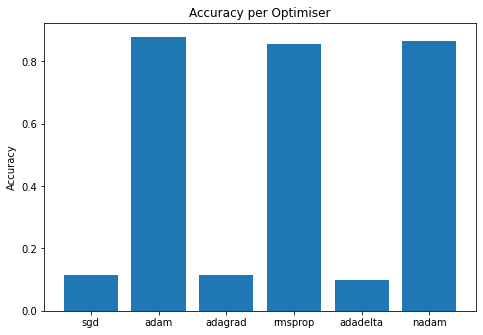

In [36]:
fig = pyplot.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(opts, [np.mean(i) for i in scores1])
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy per Optimiser')
pyplot.show()

In [40]:
def final(optimiser = 'adam'):
  input_img = Input(shape= (784, ), name='input_img')
  l = Dense(64, activation='sigmoid')(input_img)
  l = Dense(32, activation='sigmoid')(l)
  output_class = Dense( 10 , activation='softmax')(l)

  model_initial = Model(inputs=input_img, outputs=output_class)
  
  model_initial.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer= optimiser
              )
  return model_initial
model_temp  = final()
history = model_temp.fit(x_train, y_train, epochs = 20)
loss, acc = model_temp.evaluate(x_test, y_test)


Epoch 1/20
1563/1563 [==============================] - 3s 2ms/step - loss: 2.2629 - accuracy: 0.1756
Epoch 2/20
1563/1563 [==============================] - 3s 2ms/step - loss: 1.6930 - accuracy: 0.4737
Epoch 3/20
1563/1563 [==============================] - 3s 2ms/step - loss: 1.0751 - accuracy: 0.6505
Epoch 4/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.8388 - accuracy: 0.7238
Epoch 5/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.7223 - accuracy: 0.7697
Epoch 6/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6342 - accuracy: 0.8046
Epoch 7/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.5662 - accuracy: 0.8265
Epoch 8/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.5190 - accuracy: 0.8412
Epoch 9/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.4840 - accuracy: 0.8526
Epoch 10/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.457